In [1]:
'''Example script showing how to use stateful RNNs
to model long sequences efficiently.
'''
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
import lasio as las
import pandas as pd

Using TensorFlow backend.


In [20]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 100
batch_size = 250
epochs = 2
# number of elements ahead that are used to make the prediction
lahead = 1

f = las.read("/home/duys/Downloads/ccl_data/stage2b-pass4.las")
data = f['CCL']
df = pd.DataFrame(data, columns=['signal'])

def prepare_seq2seq_data(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_ahead):
        input_seq = dataset[i:(i + look_back)]
        output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
        dataX.append(input_seq)
        dataY.append(output_seq)
    dataX = np.reshape(np.array(dataX),[-1,look_back,1])
    dataY = np.reshape(np.array(dataY),[-1,look_ahead,1])
    return dataX,dataY

def gen_cosine_amp(amp=100, period=250, x0=0, xn=10013, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
        cos[i, 0, 0] += np.random.randn()

    return cos


print('Generating Data...')
#cos = gen_cosine_amp()

def clip_data(data_tuple, batch_size):
    x, y = data_tuple
    #For stateful lstm the batch_size needs to be fixed before hand.
    #We also need to ernsure that all batches shud have the same number of samples. So we drop the last batch as it has less elements than batch size
    if batch_size > 1:
        n_train_batches = len(x)/batch_size
        len_d = n_train_batches * batch_size
        if len_d < len(x):
            x = x[:len_d]
            y = y[:len_d]
        return x, y


# print(cos[0:2])
# expected_output = np.zeros((len(cos), 1))
# for i in range(len(cos) - lahead):
#     expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

#cos, expected_output = prepare_seq2seq_data(cos, tsteps, lahead)
#cos, expected_output = prepare_seq2seq_data(df.signal[1:80102].values, tsteps, lahead)
cos, expected_output = prepare_seq2seq_data(df.signal[1:].values, tsteps, lahead)
cos, expected_output = clip_data((cos, expected_output), batch_size=batch_size)

print('Input shape:', cos.shape)
print('Output shape:', expected_output.shape)
# sys.exit()
print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(batch_size, tsteps),
               batch_size=batch_size,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(Dropout(0.1))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)

    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in cos.
    # Each of these series are offset by one step and can be
    # extracted with cos[i::batch_size].

    model.fit(cos, expected_output[:, 0],
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              shuffle=False)
    model.reset_states()






Generating Data...
Input shape: (81250, 100, 1)
Output shape: (81250, 1, 1)
Creating Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (250, 100, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (250, 100, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (250, 50)                 20200     
_________________________________________________________________
dense_4 (Dense)              (250, 1)                  51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Training
Epoch 0 / 2
Epoch 1/1
81250/81250 [==============================] - 35s - loss: 0.0168    
Epoch 1 / 2
Epoch 1/1
81250/81250 [==============================] - 34s - 

In [21]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)
#predicted_output = np.roll(predicted_output, -1)

Predicting


Plotting Results


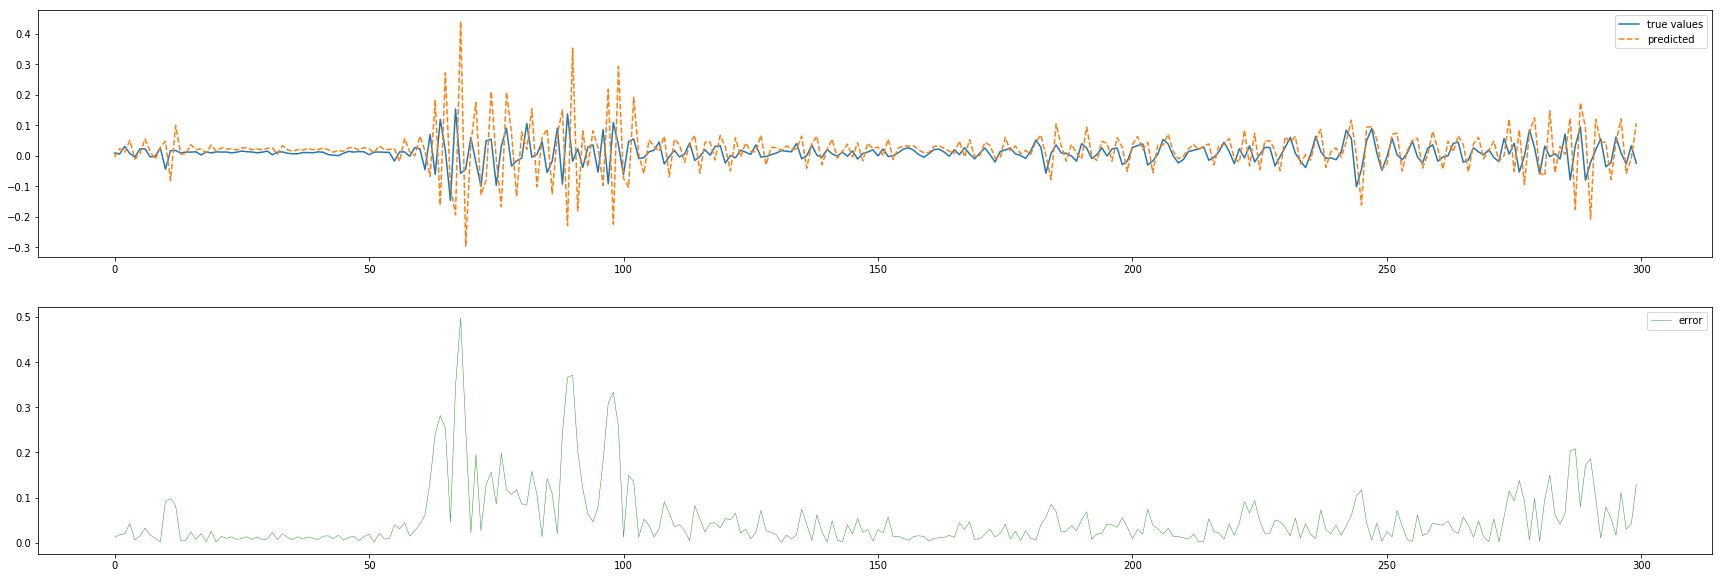

In [22]:
print('Plotting Results')

b,e = 2500, 2800

plt.figure(figsize=(30,10))
plt.subplot(2,1,1)
plt.plot(expected_output[b: e,0], label="true values")
plt.plot(predicted_output[b: e], label='predicted', linestyle='--')
plt.legend()

plt.subplot(2,1,2)
error = abs(predicted_output - expected_output[:,0])
plt.plot(error[b: e], label="error", linewidth=0.5, c='g', alpha=0.8)
plt.legend()
plt.show()

Plotting Results


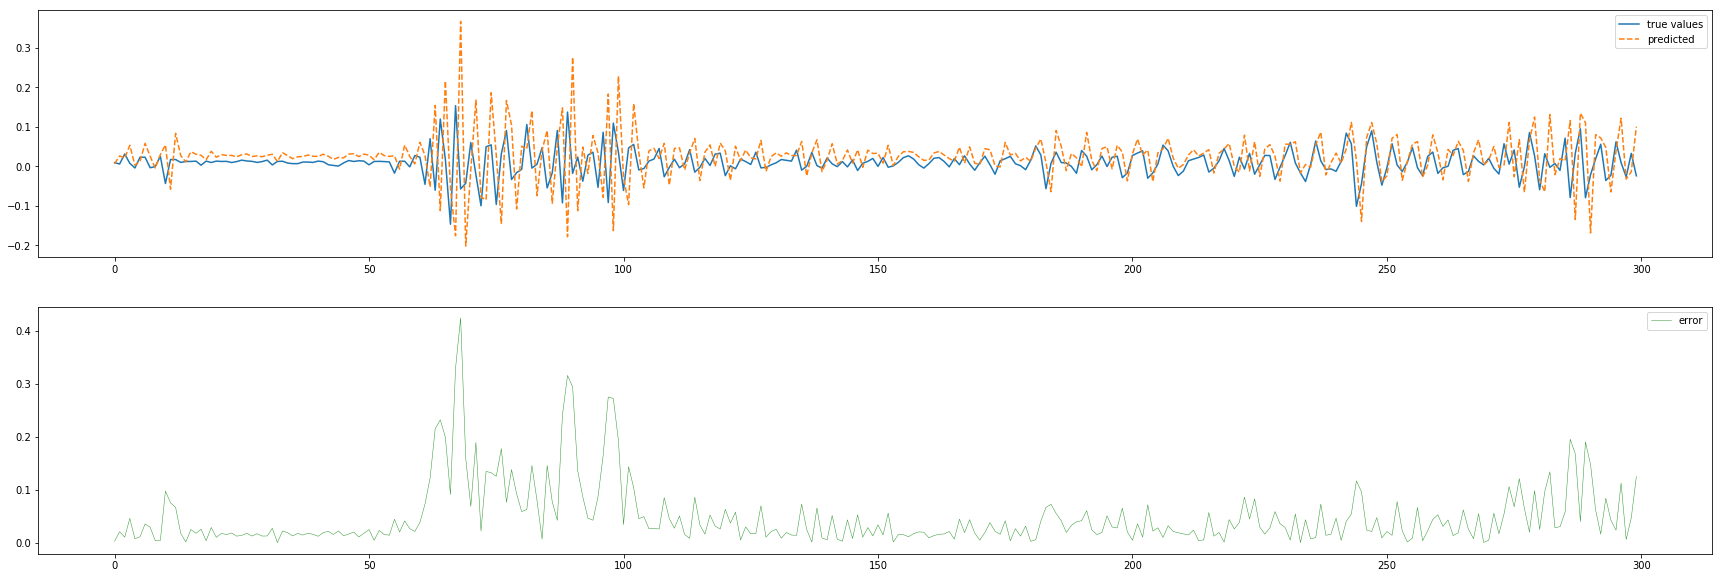

In [16]:
print('Plotting Results')

b,e = 2500, 2800

plt.figure(figsize=(30,10))
plt.subplot(2,1,1)
plt.plot(expected_output[b: e,0], label="true values")
plt.plot(predicted_output[b: e], label='predicted', linestyle='--')
plt.legend()

plt.subplot(2,1,2)
error = abs(predicted_output - expected_output[:,0])
plt.plot(error[b: e], label="error", linewidth=0.5, c='g', alpha=0.8)
plt.legend()
plt.show()

In [6]:
predicted_output.shape, cos.shape

((80000, 1), (80000, 100, 1))

In [78]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import lasio as las


class WirelineLog(object):
    """
    Read LAS File

    """
    las_file = None
    df = None


    def read(self, path):
        """
        Return DataFrame of entire las file
        :param path:
        :return:
        """
        self.las_file = las.read(path)
        self.df = self.las_file.df()


class MultiStepLTSM(Sequential):
    d_train = None
    d_valid1 = None
    d_valid2 = None
    d_test = None
    done = None
    predictions = None

    def __init__(self, data, batch_size=500, epochs=25, look_back=100, look_ahead=1, dropout=0.1, hidden_n=120):
        super(MultiStepLTSM, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.look_back = look_back
        self.look_ahead = look_ahead
        self.dropout = dropout
        self.hidden_n = hidden_n
        self.epochs = epochs

    def build_model(self, iterations=0):

        self.add(LSTM(self.hidden_n,
                      input_shape=(self.batch_size, self.look_back),
                      batch_size=self.batch_size,
                      batch_input_shape=(self.batch_size, self.look_back, self.look_ahead),
                      return_sequences=True,
                      stateful=True
                      ))

        self.add(Dropout(self.dropout))
        
        for i in range(iterations):
            self.add(LSTM(self.hidden_n,
                          return_sequences=True,
                          stateful=True
                          ))

            self.add(Dropout(self.dropout))
            

        self.add(LSTM(
            self.hidden_n,
            return_sequences=False,
            stateful=True
        ))
        self.add(Dense(1))

        optimizer = Adam(lr=0.002)
        self.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        self.summary()

    def train_model(self, predict_on=None):
        x_train, y_train = self.d_train

        for i in range(self.epochs):
            print("Epoch", i+1, "/", self.epochs)

            self.fit(x_train, y_train[:,0],
                     batch_size=self.batch_size,
                     epochs=1,
                     verbose=1,
                     shuffle=False)
            self.reset_states()

        self.done = 1
        self.predictions = self.predict(x_train, batch_size=self.batch_size)


    def plot_error(self, true, predictions, i1=None, i2=None):
        b = i1 if i1 is not None else 0
        e = i2 if i2 is not None else len(true)
        if e < b:
            tmp = b; b = e
            e = tmp
        
        plt.figure(figsize=(30,10))
        plt.subplot(2,1,1)
        plt.plot(true[b:e,0], label="True Values")
        plt.plot(predictions[b:e], label="Predicted", linestyle="--")
        plt.legend()
        plt.subplot(2,1,2)
        error = abs(predictions - true[:, 0])
        plt.plot(error[b:e], label="Error", linewidth=0.5, c='g', alpha=0.8)
        plt.legend()
        plt.show()


    def preprocess_data(self):
        """
        Preprocess fed data, assuming it is in structure:
        train,
        valid1,
        valid2,
        test
        :return: N/A
        """
        # for d in range(len(self.data)):
        self.d_train = self._prepare_seq2seq_data(self.data, look_ahead=self.look_ahead, look_back=self.look_back)
        self.d_train = self.clip_data(self.d_train)

    def _prepare_seq2seq_data(self, dataset, look_back, look_ahead):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - look_ahead):
            input_seq = dataset[i:(i + look_back)]
            output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
            dataX.append(input_seq)
            dataY.append(output_seq)
        dataX = np.reshape(np.array(dataX), [-1, look_back, 1])
        dataY = np.reshape(np.array(dataY), [-1, look_ahead, 1])
        return dataX, dataY

    def clip_data(self, data_tuple):
        x, y = data_tuple
        #For stateful lstm the batch_size needs to be fixed before hand.
        #We also need to ernsure that all batches shud have the same number of samples. So we drop the last batch as it has less elements than batch size
        if self.batch_size > 1:
            n_train_batches = len(x)/self.batch_size
            len_d = n_train_batches * self.batch_size
            if len_d < len(x):
                x = x[:len_d]
                y = y[:len_d]
            return x, y

    def plot_results(self):
        if self.done is None:
            print("Model hasn't been run yet")
            return



data = WirelineLog()
data.read("/home/duys/Downloads/ccl_data/stage2b-pass4.las")
d = data.df['CCL'].dropna().values

model2 = MultiStepLTSM(data=d, batch_size=250, look_back=100, epochs=25, hidden_n=50)
model2.build_model(iterations=1)
model2.preprocess_data()
print(model2.d_train[0].shape)
model2.train_model()
x, y = model2.d_train
#model.plot_error(x, model.predictions)
print(model2.d_train[0].shape, model2.predictions.shape)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (250, 100, 50)            10400     
_________________________________________________________________
dropout_8 (Dropout)          (250, 100, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (250, 100, 50)            20200     
_________________________________________________________________
dropout_9 (Dropout)          (250, 100, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (250, 50)                 20200     
_________________________________________________________________
dense_8 (Dense)              (250, 1)                  51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
(81250

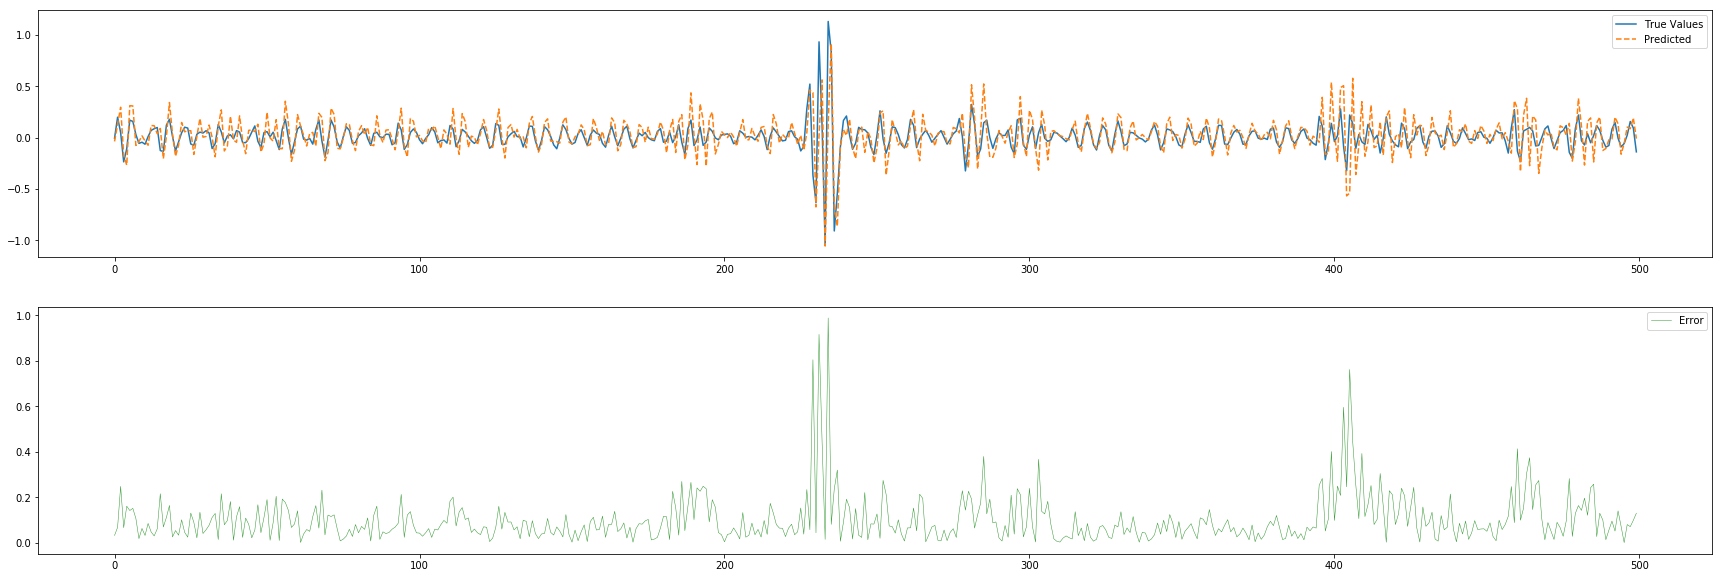

In [81]:
model2.plot_error(model2.d_train[1], model2.predictions, i1=4500, i2=5000)